In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataset_path = '/content/drive/MyDrive/MINI_PROJECT/DATASETFinal22k'

In [ ]:
from PIL import Image
import os

data = []
for split in ['TRAIN', 'TEST']:
    split_path = os.path.join(dataset_path, split)
    for label in ['O', 'R']:
        folder_path = os.path.join(split_path, label)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith(('jpg', 'jpeg')):
                    file_path = os.path.join(folder_path, file)
                    try:
                        # Attempt to open the image to verify it's valid
                        img = Image.open(file_path)
                        img.verify()  # Verify the image is not corrupted
                        img.close()
                        # Map 'O' to 'organic' and 'R' to 'recyclable'
                        label_name = 'organic' if label == 'O' else 'recyclable'
                        data.append((file_path, label_name))
                    except (Exception) as e:
                        print(f"Skipping invalid image: {file_path}, Error: {str(e)}")

df = pd.DataFrame(data, columns=['filepath', 'label'])
print(df.head())
print(f"Total images: {len(df)}")

Streaming output truncated to the last 5000 lines.
Skipping invalid image: /content/drive/MyDrive/MINI_PROJECT/DATASETFinal22k/TRAIN/R/R_6092.jpg, Error: cannot identify image file '/content/drive/MyDrive/MINI_PROJECT/DATASETFinal22k/TRAIN/R/R_6092.jpg'
Skipping invalid image: /content/drive/MyDrive/MINI_PROJECT/DATASETFinal22k/TRAIN/R/R_6093.jpg, Error: cannot identify image file '/content/drive/MyDrive/MINI_PROJECT/DATASETFinal22k/TRAIN/R/R_6093.jpg'
Skipping invalid image: /content/drive/MyDrive/MINI_PROJECT/DATASETFinal22k/TRAIN/R/R_6094.jpg, Error: cannot identify image file '/content/drive/MyDrive/MINI_PROJECT/DATASETFinal22k/TRAIN/R/R_6094.jpg'
Skipping invalid image: /content/drive/MyDrive/MINI_PROJECT/DATASETFinal22k/TRAIN/R/R_6095.jpg, Error: cannot identify image file '/content/drive/MyDrive/MINI_PROJECT/DATASETFinal22k/TRAIN/R/R_6095.jpg'
Skipping invalid image: /content/drive/MyDrive/MINI_PROJECT/DATASETFinal22k/TRAIN/R/R_6096.jpg, Error: cannot identify image file '/conte

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print("\nTraining set distribution:")
print(train_df['label'].value_counts(normalize=True) * 100)
print("\nValidation set distribution:")
print(val_df['label'].value_counts(normalize=True) * 100)

Training set size: 2010
Validation set size: 503

Training set distribution:
label
organic       55.771144
recyclable    44.228856
Name: proportion, dtype: float64

Validation set distribution:
label
organic       55.666004
recyclable    44.333996
Name: proportion, dtype: float64


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    seed=42,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    seed=42,
    shuffle=False
)

print(f"Number of training batches: {len(train_generator)}")
print(f"Number of validation batches: {len(val_generator)}")

Found 2010 validated image filenames belonging to 2 classes.
Found 503 validated image filenames belonging to 2 classes.
Number of training batches: 63
Number of validation batches: 16


In [ ]:
class_labels = train_df['label'].unique()
weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train_df['label']
)
class_weights = dict(zip(range(len(class_labels)), weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.8965209634255129), 1: np.float64(1.1304836895388077)}


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-20]:  # Fine-tune last 20 layers
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 8,933,377 (34.08 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 813ms/step - accuracy: 0.8549 - loss: 0.3199 - val_accuracy: 0.9841 - val_loss: 0.0666 - learning_rate: 1.0000e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 555ms/step - accuracy: 0.9859 - loss: 0.0335 - val_accuracy: 0.9841 - val_loss: 0.0632 - learning_rate: 1.0000e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 564ms/step - accuracy: 0.9947 - loss: 0.0162 - val_accuracy: 0.9861 - val_loss: 0.0493 - learning_rate: 1.0000e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 562ms/step - accuracy: 0.9966 - loss: 0.0117 - val_accuracy: 0.9861 - val_loss: 0.0467 - learning_rate: 1.0000e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 630ms/step - accuracy: 0.9990 - loss: 0.0075 - val_accuracy: 0.9841 - val_loss: 0.0376 - learning_rate: 1.0000e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 541ms/step - accuracy: 0.9971 - loss: 0.0085 - val_accuracy: 0.9881 - val_loss: 0.0546 - learning_rate: 1.0000e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 629ms/step - acc

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step
              precision    recall  f1-score   support

     organic       0.99      0.99      0.99       280
  recyclable       0.98      0.98      0.98       223

    accuracy                           0.98       503
   macro avg       0.98      0.98      0.98       503
weighted avg       0.98      0.98      0.98       503



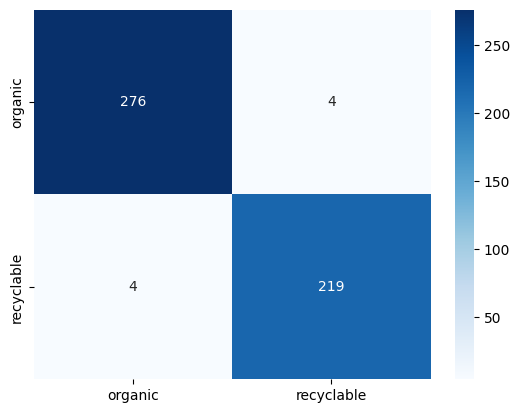

In [ ]:
val_preds = model.predict(val_generator)
val_labels = val_generator.classes
print(classification_report(val_labels, (val_preds > 0.5).astype(int), target_names=['organic', 'recyclable']))
cm = confusion_matrix(val_labels, (val_preds > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['organic', 'recyclable'], yticklabels=['organic', 'recyclable'])
plt.show()

In [ ]:
def predict_image(model, image_path):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    prediction = model.predict(img_array)
    return 'recyclable' if prediction[0][0] > 0.5 else 'organic'

from google.colab import files
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
print(f"Prediction: {predict_image(model, test_image_path)}")

Saving R_30.jpg to R_30.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction: recyclable


In [ ]:
model.save('/content/drive/MyDrive/MINI_PROJECT/waste_classification22_model.h5')